In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
print('Numpy version: {}'.format(np.__version__))
print('MatplotLib version: {}'.format(matplotlib.__version__))

Numpy version: 1.13.3
MatplotLib version: 2.1.0


In [3]:
def generate_dataset(num_data, means, covariances, weights):
    """
    """
    num_clusters = len(weights)
    print(num_clusters)
    data = []
    for _ in range(num_data):
        k = np.random.choice(num_clusters, 1, list(weights))[0]
        data.append(np.random.multivariate_normal(means[k], covariances[k]))
    return np.array(data)

In [4]:
# Model parameters
init_means = np.array([
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[1., .7], [0, .7]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
])

init_weights = np.array([1/4., 1/2., 1/4.])  # weights of each cluster

# Generate data
np.random.seed(4017)
data = generate_dataset(250, init_means, init_covariances, init_weights)

3


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


In [5]:
multivariate_normal.pdf(data[0], init_means[0], init_covariances[0])

0.17846903498713204

In [6]:
np.random.choice(2, 1, list(np.array([0.2, 0.7, 0.1])))

array([1])

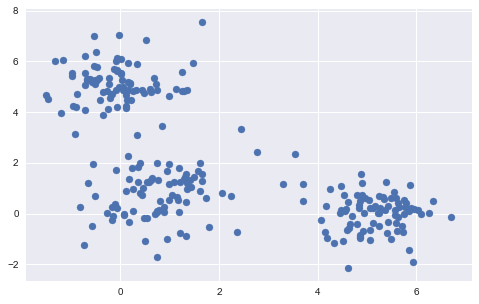

In [7]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [8]:
def log_likelihood(data, means, covariances, weights):
    def log_sum_exp(Z):
        return np.max(Z) + np.log(np.sum(np.exp(Z) - np.max(Z)))
    
    ll = 0
    num_clusters = len(weights)
    num_dim = data.shape[1]
    
    for d in data:
        Z = np.zeros(num_clusters)
        
        for k in range(num_clusters):
            delta = (d - means[k])
            #print(covariances[k])
            exp_term = np.transpose(delta) @ np.linalg.inv(covariances[k]) @ delta
            
            #print(np.log(weights[k]))
            Z[k] += np.log(weights[k])
            Z[k] -= 0.5*(num_dim*np.log(2*np.pi) + np.log(np.linalg.det(covariances[k])) + exp_term)
        ll += log_sum_exp(Z)
    return ll       

In [9]:
log_likelihood(data, init_means, init_covariances, init_weights)

-285.27082798553954

In [10]:
def k_means_em(data, init_means, init_covs, init_weights, maxiter=1000, thresh=1e-4):
    # make copies
    means = np.copy(init_means)
    covs = np.copy(init_covs)
    weights = np.copy(init_weights)
    
    num_data = data.shape[0]
    num_dim = data.shape[1]
    num_clusters = len(init_weights)
    
    # some useful variables 
    q = np.zeros((num_data, num_clusters))
    ll = log_likelihood(data, means, covs,  weights)
    ll_trace = [ll]
    
    for i in range(maxiter):
        print(i)
        
        # E step
        for j in range(num_data):
            for k in range(num_clusters):
                #print(means[k])
                q[j, k] = weights[k] * multivariate_normal.pdf(data[j], means[k], covs[k])
        
        row_sums = np.sum(q, axis=1, keepdims=True)
        
        q = q / row_sums
        #print(q)
        
        # M step
        for k in range(num_clusters):
            weights[k] = np.sum(q[:, k]) / num_data
            
            weighted_sum = 0
            for i in range(num_data):
                weighted_sum += q[i][k]*data[i]
            means[k] = weighted_sum / np.sum(q[:, k])
            
            #print(means)
            weighted_cov = np.zeros((num_dim, num_dim))
            for i in range(num_data):
                #delta = (data[i] - means[k])
                weighted_cov += q[i][k] * np.outer((data[i] - means[k]), (data[i] - means[k]))
                #print(delta @ np.transpose(delta))
            covs[k, :] = weighted_cov / np.sum(q[:, k])
            
        #print(weighted_cov / np.sum(q[:, k]))
        ll_latest = log_likelihood(data, means, covs,  weights)
        print(ll_latest)
        ll_trace.append(ll_latest)
    
        if (ll_latest - ll) < thresh:
            break
        ll = ll_latest
    
    out = {'weights': weights, 'means': means, 'covs': covs, 'loglik': ll_trace, 'resp': q}
    return out 
        
    

In [29]:
# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = np.array([data[70], data[80], data[90]])
initial_covs =  np.array([
    [[1, 0.], [0, 1]], # covariance of cluster 1
    [[1, 0.], [0, 1]], # covariance of cluster 2
    [[1, 0.], [0, 1]]  # covariance of cluster 3
])
initial_weights = np.array([1/3, 1/3, 1/3])

results = k_means_em(data, initial_means, initial_covs, initial_weights)

0
-272.177303865
1
-271.786665331
2
-271.667253573
3
-271.603223138
4
-271.466654263
5
-271.34193353
6
-271.277968282
7
-271.245221831
8
-271.228227006
9
-271.219290478
10
-271.214552385
11
-271.212029844
12
-271.210684601
13
-271.20996689
14
-271.209584024
15
-271.209379844
16
-271.209270993
17
-271.20921298


In [30]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

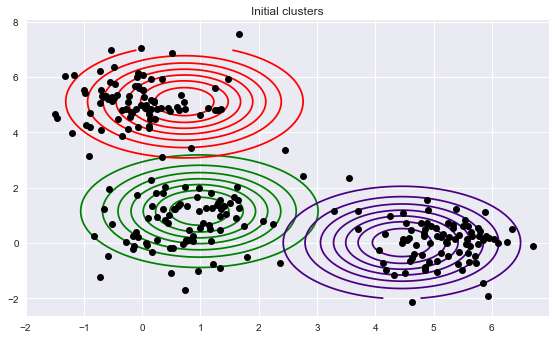

In [31]:
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

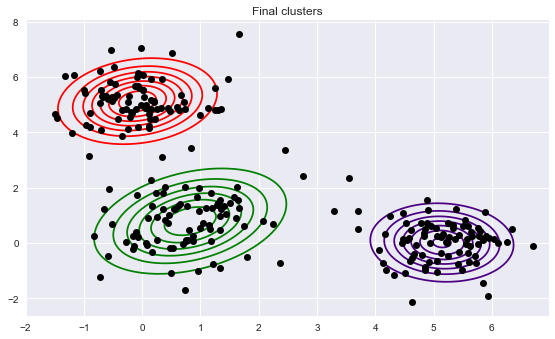

In [33]:
plot_contours(data, results['means'], results['covs'], 'Final clusters')

In [34]:
results['covs']

array([[[ 0.7048177 ,  0.21718028],
        [ 0.21718028,  0.94094486]],

       [[ 0.45227563,  0.04729535],
        [ 0.04729535,  0.58791861]],

       [[ 0.38217954, -0.01232517],
        [-0.01232517,  0.51034852]]])

In [35]:
initial_covs

array([[[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]]])